In [155]:
import sklearn
from sklearn.datasets import fetch_olivetti_faces
from sklearn.datasets import fetch_openml
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


In [156]:
datasets_path = "../../../../datasets_data/faces_data"

olivetti_faces = fetch_openml(name='olivetti_faces',
                              data_home=datasets_path,
                              version=1,
                              as_frame=False
)

In [157]:
face_data, face_target = olivetti_faces.data, olivetti_faces.target

face_target = face_target.astype(int)

face_data = torch.tensor(face_data, dtype=torch.float)
face_target = torch.tensor(face_target, dtype=torch.long)

dataset = [(img,lbl) for img,lbl in zip(face_data, face_target)]
train_data = DataLoader(dataset, batch_size=10, shuffle=True)

In [158]:
#  定义神经网络模型, 不带归一化和正则化
class MLPClassifier1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(64*64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 40)  # Olivetti有40个类别
        )

    def forward(self, x):
        return self.layers(x)

In [159]:
#  定义神经网络模型, 带归一化
class MLPClassifier2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(64*64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 40)  # Olivetti有40个类别
        )

    def forward(self, x):
        return self.layers(x)

In [160]:
#  定义神经网络模型, 带归一化和正则化
class MLPClassifier3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(64*64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),  # 正则化
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 40)  # Olivetti有40个类别
        )

    def forward(self, x):
        return self.layers(x)

In [161]:
models = {
    "Original model": MLPClassifier1(),
    "BatchNorm1d model": MLPClassifier2(),
    "bn and Dropout": MLPClassifier3()
}

In [162]:
# 损失函数和优化器
criterion = nn.CrossEntropyLoss()

def optimizers(model_name):
    return optim.SGD(models[model_name].parameters(), lr=0.01, weight_decay=1e-4)

In [163]:
# 训练函数
def train_model(model_name, num_epochs=20):
    model = models[model_name]
    optimizer = optimizers(model_name)
    train_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0

        for images, labels in train_data:
            model.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_data.dataset)
        train_losses.append(epoch_loss)
        # print(f"{model_name} Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")

    return train_losses

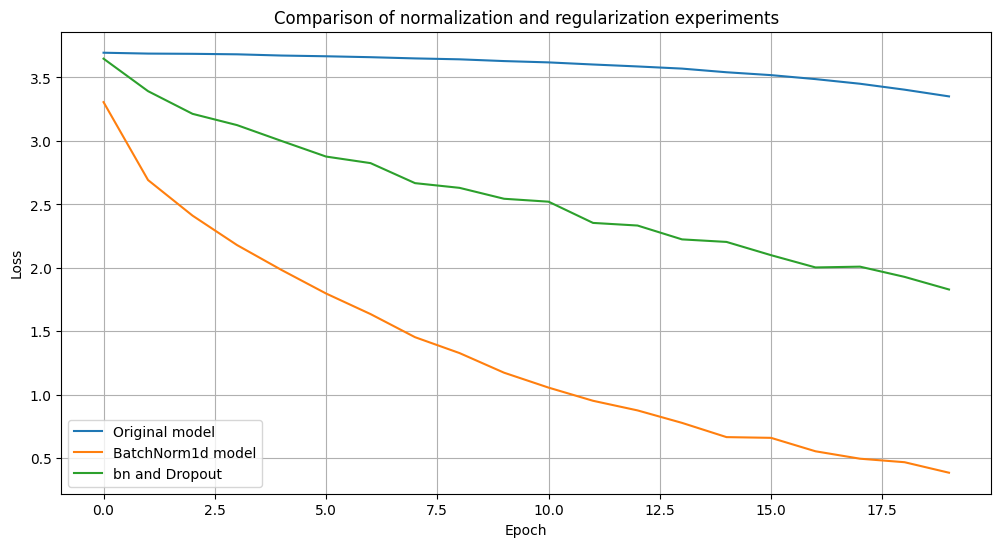

In [164]:
# 执行训练和可视化

plt.figure(figsize=(12, 6))

for model_name in models.keys():
    losses = train_model(model_name, num_epochs=20)
    plt.plot(losses, label=model_name)

plt.title("Comparison of normalization and regularization experiments")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()